# End-to-End Memory Network for Question Answering

> What is an **end-to-end** network?  

-  All learning is done inside the network (a learned output for a given input)
-  All modules are differentiable. 
 

> What is a **memory** network?  

- Intuitively models the human process for processing data for a particular solution or goal
- Modern models closely related to Neural Turing Machine (Graves) and earlier works.
- End-to-End network's major difference is softmax instead of hardmax over query + memory space

***"What if all NLP problems could be seen as a question-answering problem?"***  - Socher, et al.

> This notebook presents an architecture developed by Sukhbaatar, Weston, et. al. 

https://arxiv.org/pdf/1503.08895.pdf

> with Facebook researchers (where the next 2 slides came from) to approach this task using neural networks. The fundamental idea I think is the way the facts are combined multiple times with the queries to build a distribution the most probably reflects the amount of information supplied by the fact to the query to best predict the correct answer. 


> The dataset used is the Facebook babl dataset. It's a very contrived dataset of fact, question scenarios, grouped into 20 distinct reasoning tasks of varying difficulty. But as Socher says, "If your model can't perform well on this, you have no hope of performing well on more complicated, realistic tasks."  It's available here: https://research.fb.com/downloads/babi/

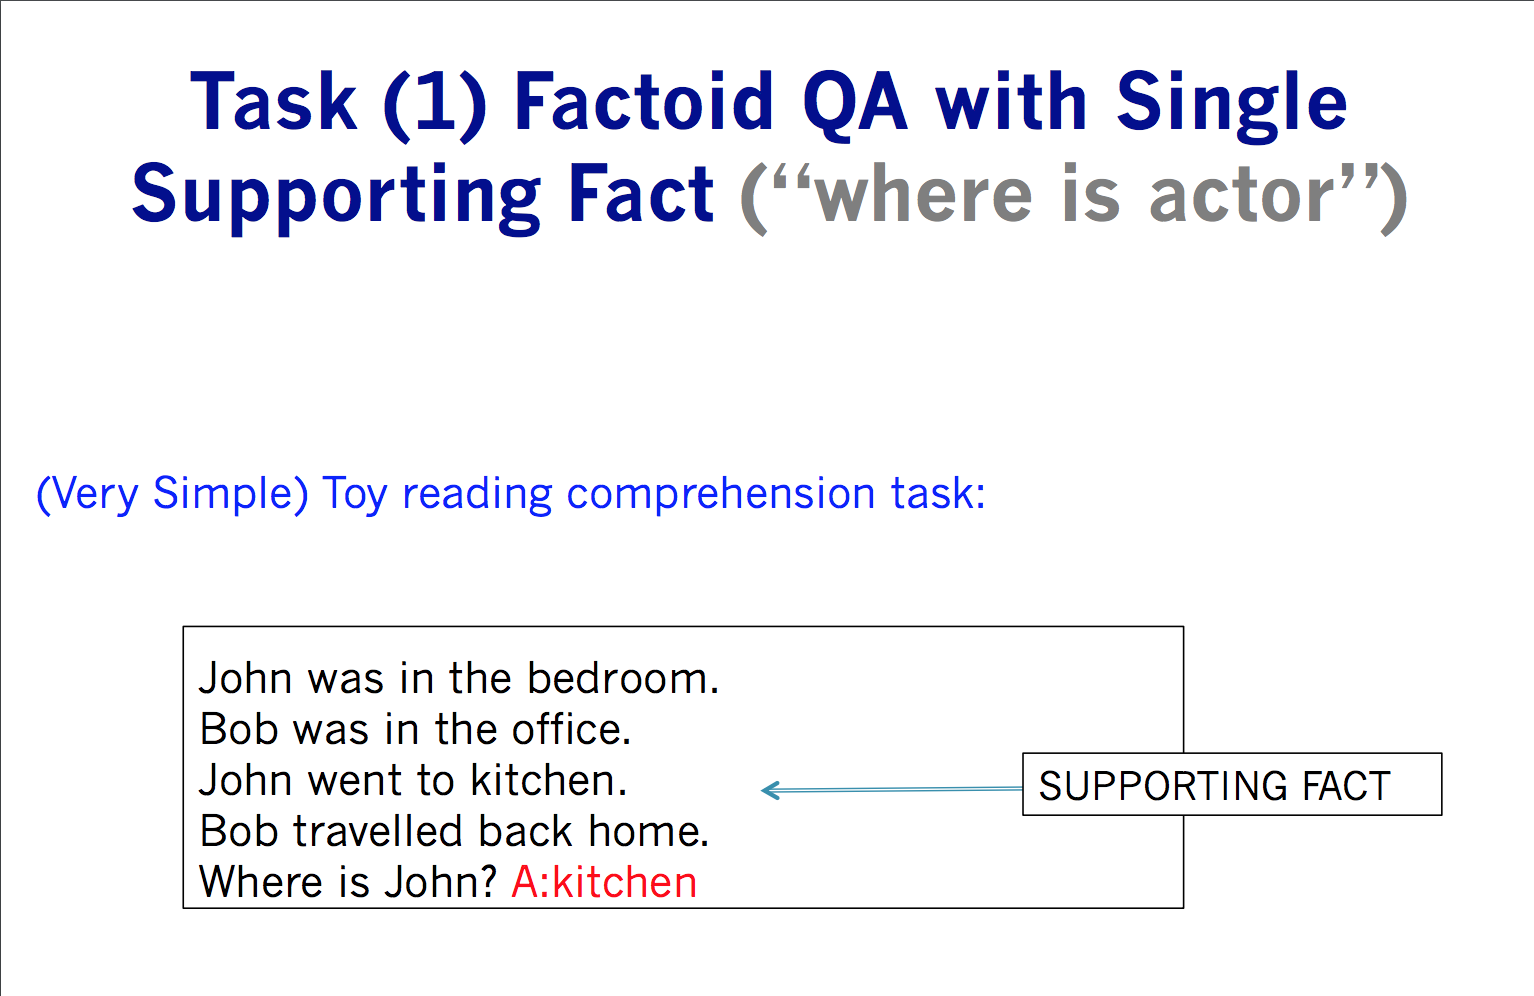

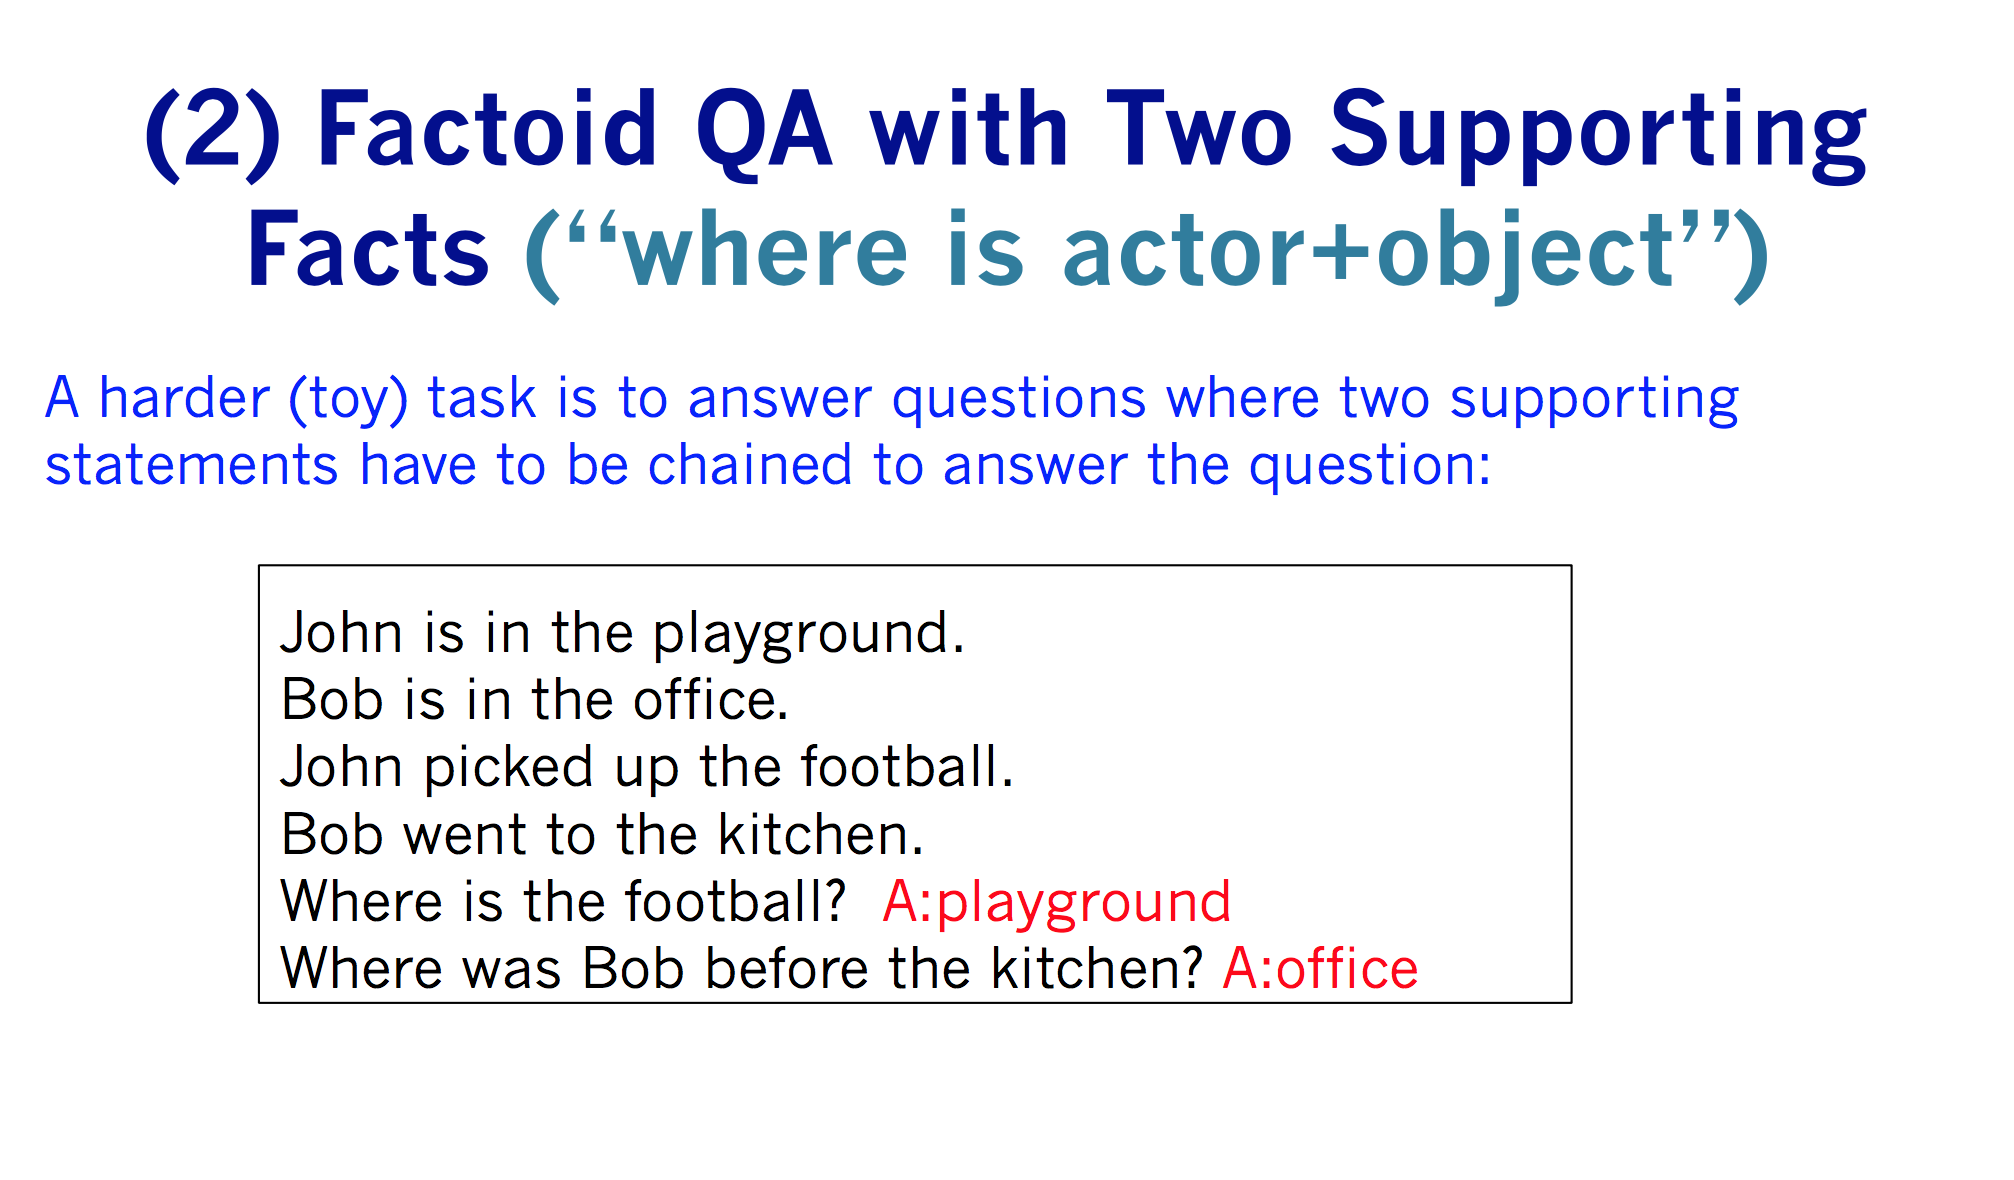

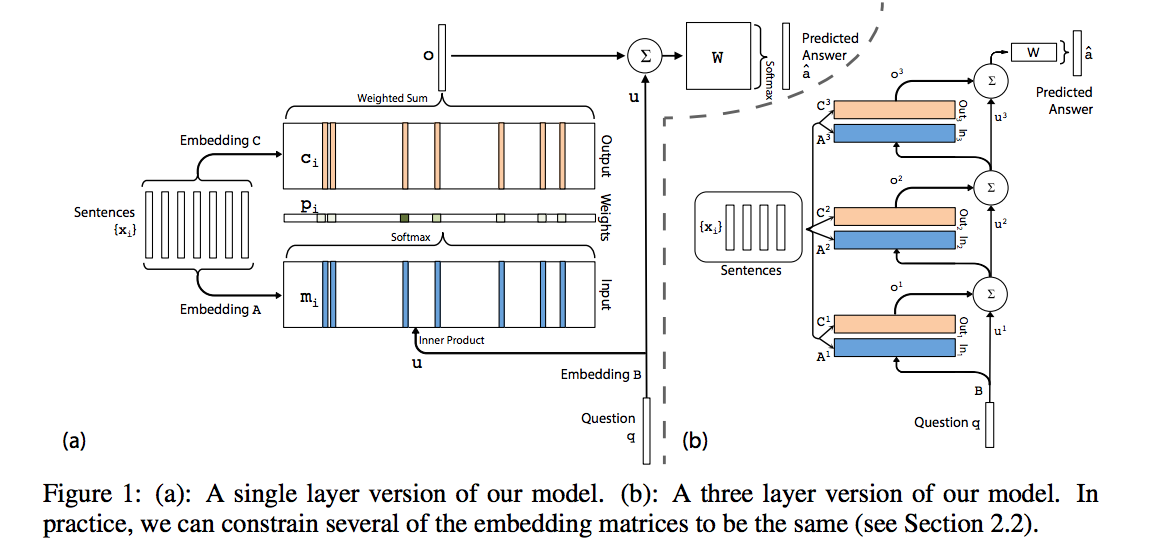

In [1]:
%matplotlib inline

from keras.layers import Input, Embedding, Lambda, Activation, Dense, Reshape, RepeatVector, Dropout
from keras.preprocessing.text import one_hot
from keras import backend as K 
from keras.models import Model
import pandas as pd
import numpy as np
import string
import keras
import copy
import re
import os






def task_eval(task_num, task_dir="./tasks_1-20_v1-2/en"):
    
    
    task_files = sorted(os.listdir(task_dir))
    if not task_files[0].endswith('.txt'):  #there's a sneaky .ipynb file that was getting into this list, at beginning
        task_files = task_files[1:] 
        
    test_file = [f for f in task_files if f'qa{task_num}_' in f and 'test' in f][0]
    train_file = [f for f in task_files if f'qa{task_num}_' in f and 'train' in f][0]
    
    test_mems, test_queries, test_answers = structure_tasks(task_dir, test_file)
    train_mems, train_queries, train_answers = structure_tasks(task_dir, train_file)
    return (train_mems, train_queries, train_answers), (test_mems, test_queries, test_answers)





"""
#return a tuple of memory (fact) sentences, query sentences, and answers, for every QA set in data
def structure_tasks(task_dir, task_num):

    task_files = os.listdir(task_dir)
    memories, queries, answers = [], [], []
    mems_i = []
    last = 0

    for line in open(task_dir + '/' + task_files[task_num], 'r').readlines():
        line = line.split()
        n = int(line[0])

        if line[-1].isnumeric():
            queries.append([line[1:-2]])   #not keeping the strong supervision of the supporting memory indexes
            answers.append([line[-2]])
            add_mems = copy.copy(mems_i)[::-1] #reverse as in 4.1 of article
            memories.append(add_mems)

        elif n >= last:  #should never be ==
            last = n
            mems_i.append(line[1:])

        elif n < last:
            last = n
            mems_i = [line[1:]]


    return memories, queries, answers
    
"""
#return a tuple of memory (fact) sentences, query sentences, and answers, for every QA set in data
def structure_tasks(task_dir, filename):

   
    memories, queries, answers = [], [], []
    mems_i = []
    last = 0
    
    supporting = []

    for j, line in enumerate(open(task_dir + '/' + filename, 'r').readlines()):
        
        supp = []
        line = line.split()
        n = int(line[0])

        supp = [i for i in line if i.isnumeric()]
        supporting.append(supp)
        if line[-1].isnumeric():
            
            
            q_end = [i for (i, w) in enumerate(line) if w.endswith('?')][0]
            
            queries.append([line[1:q_end + 1]])   #not keeping the strong supervision of the supporting memory indexes
            
            
            answers.append([line[-2]])  #dont do lists this iteration...
           
           
            add_mems = copy.copy(mems_i)[::-1] #reverse as in 4.1 of article
            memories.append(add_mems)
            
            #print(len(answers), len(queries), len(memories))

        elif n >= last:  #should never be ==
            last = n
            mems_i.append(line[1:])

        elif n < last:
            last = n
            mems_i = [line[1:]]
            
   


    return memories, queries, answers




#NOT USED (yet)
def get_pre_trained(filename):

    pre_trained_embeddings = {}
    for line in open(filename, 'r').readlines():
        line = line.split()
        pre_trained_embeddings[line[0]] = np.array(line[1:])

    return pre_trained_embeddings


Using TensorFlow backend.


In [2]:
#DATA
(tr_mems, tr_qs, tr_ans), (ts_mems, ts_qs, ts_ans) = task_eval(1)

In [3]:
for i in range(5):
    print(f"Problem {i}")
    print(tr_mems[i], tr_qs[i], tr_ans[i])
    print(ts_mems[i], ts_qs[i], ts_ans[i])

Problem 0
[['John', 'went', 'to', 'the', 'hallway.'], ['Mary', 'moved', 'to', 'the', 'bathroom.']] [['Where', 'is', 'Mary?']] ['bathroom']
[['Mary', 'journeyed', 'to', 'the', 'bathroom.'], ['John', 'travelled', 'to', 'the', 'hallway.']] [['Where', 'is', 'John?']] ['hallway']
Problem 1
[['Sandra', 'moved', 'to', 'the', 'garden.'], ['Daniel', 'went', 'back', 'to', 'the', 'hallway.'], ['John', 'went', 'to', 'the', 'hallway.'], ['Mary', 'moved', 'to', 'the', 'bathroom.']] [['Where', 'is', 'Daniel?']] ['hallway']
[['John', 'moved', 'to', 'the', 'bedroom.'], ['Daniel', 'went', 'back', 'to', 'the', 'bathroom.'], ['Mary', 'journeyed', 'to', 'the', 'bathroom.'], ['John', 'travelled', 'to', 'the', 'hallway.']] [['Where', 'is', 'Mary?']] ['bathroom']
Problem 2
[['Sandra', 'journeyed', 'to', 'the', 'bathroom.'], ['John', 'moved', 'to', 'the', 'office.'], ['Sandra', 'moved', 'to', 'the', 'garden.'], ['Daniel', 'went', 'back', 'to', 'the', 'hallway.'], ['John', 'went', 'to', 'the', 'hallway.'], ['Ma

In [4]:
def get_vocab(mems, queries, ans):
    vocab = set(v_w.strip(string.punctuation).lower() for m in mems for v_w in set(w for s in m for w in s))
    vocab = vocab.union(set(v_w.strip(string.punctuation).lower() for m in queries for v_w in set(w for s in m for w in s)))
    vocab = vocab.union(set(a[0].strip(string.punctuation).lower() for a in ans))
    return vocab


def encoder(mems, queries, ans, emb_dims, MAX_MEM_LEN, MAX_SEN_LEN, vocab):


    encoded_qs, encoded_mems, encoded_as = [], [], []
    for q_i, m_i, a_i in zip(queries, mems, ans):

        #encode questions
        q_hot_text = one_hot(' '.join(q_i[0]).strip(string.punctuation).strip('\n'), len(vocab))
        q_hot_text += ([0] * (MAX_SEN_LEN - len(q_hot_text)))
        encoded_qs.append(q_hot_text)     

        #encode memories
        m_hot_texts = []
        for m in m_i:
            m_sen_enc = one_hot(' '.join(m).strip(string.punctuation).strip('\n'), len(vocab))
            m_sen_enc += ([0] * (MAX_SEN_LEN - len(m_sen_enc))) 
            m_hot_texts.append(m_sen_enc)  

        if len(m_hot_texts) < MAX_MEM_LEN:
            m_hot_texts = np.append(m_hot_texts, [([0] * MAX_SEN_LEN) for _ in range(MAX_MEM_LEN - len(m_hot_texts))], axis=0)

        encoded_mems.append(m_hot_texts)
        
        #encode answers
        encoded_as.append(one_hot(' '.join(a_i).strip(string.punctuation).strip('\n'), len(vocab)))
        
    
    return encoded_qs, encoded_mems, encoded_as



#position encoder
def pe(mems):
    
    pe_vec = np.zeros((MAX_SEN_LEN, emb_dims))
    for pos in range(1, MAX_SEN_LEN + 1):
        for k in range(1, emb_dims + 1):
            v = (1 - pos / MAX_SEN_LEN) - (k / emb_dims) * (1 - (2 * pos / MAX_SEN_LEN))
            pe_vec[pos - 1][k - 1] = v

    
    pe_vec = K.variable(pe_vec)
 
    pe_vec = K.expand_dims(pe_vec, axis=0)
    pe_vec = K.expand_dims(pe_vec, axis=0)
    pe_vec = K.repeat_elements(pe_vec, MAX_MEM_LEN, axis=1)
    pe_vec = K.repeat_elements(pe_vec, batch_size, axis=0)
    
    
    return mems * pe_vec




In [5]:
#parameters for the model 
emb_dims = 30
n_hops = 3
n_epochs = 200
batch_size = 25
time_embed = True
pos_encode = True
vocab = get_vocab(tr_mems, tr_qs, tr_ans)
MAX_MEM_LEN = max([len(m) for m in tr_mems])
MAX_SEN_LEN = max([len(s) for m in tr_mems for s in m])


#one hot encoded forms of the data, i.e. each sentence is a row of word embeddings, weighted by the position of the word
tr_encoded_qs, tr_encoded_mems, tr_encoded_as = encoder(tr_mems, tr_qs, tr_ans, emb_dims, MAX_MEM_LEN, MAX_SEN_LEN, vocab)
ts_encoded_qs, ts_encoded_mems, ts_encoded_as = encoder(ts_mems, ts_qs, ts_ans, emb_dims, MAX_MEM_LEN, MAX_SEN_LEN, vocab)

        
        

In [6]:
tr_encoded_mems[0], tr_encoded_qs[0], tr_encoded_as[0]

(array([[ 8,  4,  8,  6,  1,  0],
        [14,  5,  8,  6,  1,  0],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0]]), [12, 12, 14, 0, 0, 0], [1])

In [7]:
#declaring the form of the input layers
x_mems = Input(batch_shape=(batch_size, MAX_MEM_LEN, MAX_SEN_LEN), name='mem_input')
x_qs = Input(batch_shape=(batch_size, MAX_SEN_LEN), name='q_input')


#A, B memory and question embeddings, respectively
A = [Embedding(len(vocab) + 1, emb_dims, embeddings_initializer='truncated_normal', mask_zero=True) for _ in range(n_hops + 1)]
B = A[0]




#time encoders, implements Random Noise of 10% zeros to TA or TC if RN True in model parameters      
class TimeLayer(keras.layers.Layer):
    
    def __init__(self, t, RN, MAX_MEM_LEN, emb_dims, **kwargs):
        self.t = t
        self.MAX_MEM_LEN = MAX_MEM_LEN
        self.emb_dims = emb_dims
        super(TimeLayer, self).__init__(**kwargs)    
        
    def build(self, input_shape):
        if self.t == "TA":
            self.W = self.add_weight(shape=(input_shape[1], input_shape[2]), initializer='truncated_normal', name="TA")
        elif self.t == "TC":
            self.W = self.add_weight(shape=(input_shape[1], input_shape[2]), initializer='truncated_normal', name="TC")
        super().build((self.MAX_MEM_LEN, self.emb_dims))

    def call(self, inputs):
        
        if RN:
            w_size = np.prod(K.int_shape(self.W))     #randomly mask out 10% of TA, TC layers per 4.1
            noise = np.ones(w_size)
            noise[:int(w_size * 0.1)] = 0
            np.random.shuffle(noise)
            noise = noise.reshape(self.W.shape)
            T = inputs + self.W * noise
        else:
            T = inputs + self.W
        
        return T
"""


#time encoder layer       
class TimeLayer(keras.layers.Layer):
    
    def __init__(self, t, **kwargs):
        self.t = t
        super(TimeLayer, self).__init__(**kwargs)    
        
    def build(self, input_shape):
        if self.t == "TA":
            self.W = self.add_weight(shape=(input_shape[1], input_shape[2]), initializer='truncated_normal', name="TA")
        elif self.t == "TC":
            self.W = self.add_weight(shape=(input_shape[1], input_shape[2]), initializer='truncated_normal', name="TC")
        super().build((MAX_MEM_LEN, emb_dims))

    def call(self, inputs):
        return inputs + self.W    

"""
    
RN = True
TA = TimeLayer("TA", RN, MAX_MEM_LEN, emb_dims)
TC = TimeLayer("TC", RN, MAX_MEM_LEN, emb_dims)


#TA = TimeLayer("TA")
#TC = TimeLayer("TC")


u = Dropout(0.1)(Lambda(lambda args: K.sum(B(args), axis=1), name='embedding_sum')(x_qs))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
#utility functions
add = Lambda(lambda args: args[0] + args[1], name='add')
sum_2 = Lambda(lambda args: K.sum(args, axis=2), name='sum_2')



for k in range(n_hops):
    
    m = Dropout(0.1)(A[k](x_mems))   #embed the encoded memories
    c = Dropout(0.1)(A[k+1](x_mems))
    
    if time_embed:
        
        m = Lambda(pe, name="pos_encoding_hop" + str(k))(m)   #positionally encode the embeddings
        m = sum_2(m)                                          #collapse into single d x |V| vector 
        c = sum_2(c)                                          #collapse into single d x |V| vector 
    
        m = TA(m)                                              #apply time information
        c = TC(c)
        
    else:
        m = sum_2(m)
        c = sum_2(c)
 

    u_map = RepeatVector(m.shape[1])(u)                      #scale q vector for memory size
    
    p = Lambda(lambda args: args[0] * args[1])([m, u_map])   #apply similarity function between mem, q for each pair
    p = sum_2(p)
    p = Activation('softmax')(p)                             #compute distribution of similarity  
    p = Reshape((1, p.shape[1]))(p)
    
    o = Lambda(lambda args: K.batch_dot(args[0], args[1]), name="batch_mul_hop" +str(k))([p, c])  #apply similarity to mems
    o = Lambda(lambda x: K.sum(x, axis=1), name="collapse_o_hop" + str(k))(o)                     #collapse into single d x |V|
    
    u = add([u, o])                                          #apply to embedded q vector at end of each hop
    

#weights shared as described in 4.1 (only initially here though??)
def loss_init(args):
    return K.transpose(A[-1].weights[0])


def custom_loss(u):
    W =  K.transpose(A[-1].weights[0])
    out = K.dot(u, W)
    return K.softmax(out)
    
    



#output for network (p(each word in vocab|(mems, q)))
out = Dense(len(vocab) + 1, kernel_initializer=loss_init, activation='softmax')(u)   

#out = Lambda(custom_loss, name="out_layer")(u)




In [9]:
model = Model(inputs=[x_mems, x_qs], outputs=out)
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mem_input (InputLayer)          (25, 10, 6)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         multiple             600         mem_input[0][0]                  
__________________________________________________________________________________________________
q_input (InputLayer)            (25, 6)              0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (25, 10, 6, 30)      0           embedding_1[2][0]                
__________________________________________________________________________________________________
embedding_

In [10]:
from keras.callbacks import LearningRateScheduler, TensorBoard


def scheduler(epoch):
    if epoch%50==0 and epoch!=0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr*.95)
        print(f"lr changed to {lr*.95}")
    return K.get_value(model.optimizer.lr)

lr_decay = LearningRateScheduler(scheduler)
tb_graph = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)



In [11]:
#sparse_cat_cross.. allows the y vector to not have to be made into one-hot vectors (integers representing single target word)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit([tr_encoded_mems, tr_encoded_qs], np.concatenate(tr_encoded_as),
                  shuffle=True,
                  epochs=n_epochs,  
                  batch_size=batch_size,
                  verbose=2,
                  validation_split=0.1,
                  callbacks=[lr_decay, tb_graph]
                  )

Instructions for updating:
Use tf.cast instead.
Train on 900 samples, validate on 100 samples
Epoch 1/200
 - 5s - loss: 1.9545 - acc: 0.4800 - val_loss: 1.5525 - val_acc: 0.3700
Epoch 2/200
 - 1s - loss: 1.3005 - acc: 0.5089 - val_loss: 1.4408 - val_acc: 0.3700
Epoch 3/200
 - 1s - loss: 1.2475 - acc: 0.5089 - val_loss: 1.4093 - val_acc: 0.3700
Epoch 4/200
 - 1s - loss: 1.2385 - acc: 0.5089 - val_loss: 1.3864 - val_acc: 0.3700
Epoch 5/200
 - 1s - loss: 1.2208 - acc: 0.5089 - val_loss: 1.3658 - val_acc: 0.3700
Epoch 6/200
 - 1s - loss: 1.1972 - acc: 0.5089 - val_loss: 1.3246 - val_acc: 0.3700
Epoch 7/200
 - 1s - loss: 1.1758 - acc: 0.5089 - val_loss: 1.3106 - val_acc: 0.3700
Epoch 8/200
 - 1s - loss: 1.1483 - acc: 0.5089 - val_loss: 1.2629 - val_acc: 0.3900
Epoch 9/200
 - 1s - loss: 1.1167 - acc: 0.5256 - val_loss: 1.2270 - val_acc: 0.4000
Epoch 10/200
 - 2s - loss: 1.0818 - acc: 0.5322 - val_loss: 1.1922 - val_acc: 0.4300
Epoch 11/200
 - 1s - loss: 1.0574 - acc: 0.5456 - val_loss: 1.181

Epoch 94/200
 - 1s - loss: 0.3491 - acc: 0.8722 - val_loss: 0.3695 - val_acc: 0.8800
Epoch 95/200
 - 1s - loss: 0.3217 - acc: 0.8856 - val_loss: 0.3672 - val_acc: 0.8900
Epoch 96/200
 - 1s - loss: 0.3111 - acc: 0.8956 - val_loss: 0.3706 - val_acc: 0.8500
Epoch 97/200
 - 1s - loss: 0.2983 - acc: 0.8922 - val_loss: 0.3435 - val_acc: 0.8700
Epoch 98/200
 - 1s - loss: 0.3241 - acc: 0.8856 - val_loss: 0.3416 - val_acc: 0.9000
Epoch 99/200
 - 1s - loss: 0.3173 - acc: 0.8978 - val_loss: 0.3441 - val_acc: 0.8800
Epoch 100/200
 - 1s - loss: 0.3221 - acc: 0.8933 - val_loss: 0.3291 - val_acc: 0.8900
Epoch 101/200
lr changed to 0.0009025000152178108
 - 1s - loss: 0.2873 - acc: 0.9000 - val_loss: 0.3097 - val_acc: 0.8700
Epoch 102/200
 - 1s - loss: 0.3097 - acc: 0.8911 - val_loss: 0.3021 - val_acc: 0.8700
Epoch 103/200
 - 1s - loss: 0.3053 - acc: 0.8922 - val_loss: 0.3105 - val_acc: 0.9000
Epoch 104/200
 - 1s - loss: 0.2786 - acc: 0.9089 - val_loss: 0.3254 - val_acc: 0.8900
Epoch 105/200
 - 1s - lo

Epoch 189/200
 - 1s - loss: 0.1463 - acc: 0.9578 - val_loss: 0.2425 - val_acc: 0.9200
Epoch 190/200
 - 1s - loss: 0.1625 - acc: 0.9456 - val_loss: 0.2403 - val_acc: 0.9300
Epoch 191/200
 - 1s - loss: 0.1780 - acc: 0.9456 - val_loss: 0.2289 - val_acc: 0.9200
Epoch 192/200
 - 1s - loss: 0.1799 - acc: 0.9367 - val_loss: 0.2595 - val_acc: 0.9200
Epoch 193/200
 - 1s - loss: 0.1473 - acc: 0.9478 - val_loss: 0.2189 - val_acc: 0.9300
Epoch 194/200
 - 1s - loss: 0.1666 - acc: 0.9511 - val_loss: 0.2333 - val_acc: 0.9200
Epoch 195/200
 - 1s - loss: 0.1638 - acc: 0.9489 - val_loss: 0.2339 - val_acc: 0.9200
Epoch 196/200
 - 1s - loss: 0.1578 - acc: 0.9489 - val_loss: 0.2381 - val_acc: 0.9300
Epoch 197/200
 - 1s - loss: 0.1566 - acc: 0.9533 - val_loss: 0.2350 - val_acc: 0.9200
Epoch 198/200
 - 1s - loss: 0.1680 - acc: 0.9500 - val_loss: 0.2583 - val_acc: 0.9300
Epoch 199/200
 - 1s - loss: 0.1494 - acc: 0.9567 - val_loss: 0.2155 - val_acc: 0.9300
Epoch 200/200
 - 1s - loss: 0.1559 - acc: 0.9489 - val

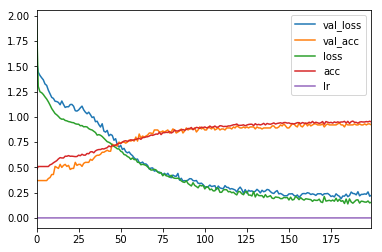

In [13]:
pd.DataFrame(history.history).plot();   #thanks Alex :)


In [14]:
score = model.evaluate([ts_encoded_mems, ts_encoded_qs], np.concatenate(ts_encoded_as), verbose=0, batch_size=batch_size)
print('Test accuracy:', score[1])

Test accuracy: 0.902999997138977


> You can tell the accuracy is close to what the cited paper reported for this, the first task, with 1 supporting fact, as shown in the table below. It shows 0% error for 2 hops, and 0% error for 3 hops:
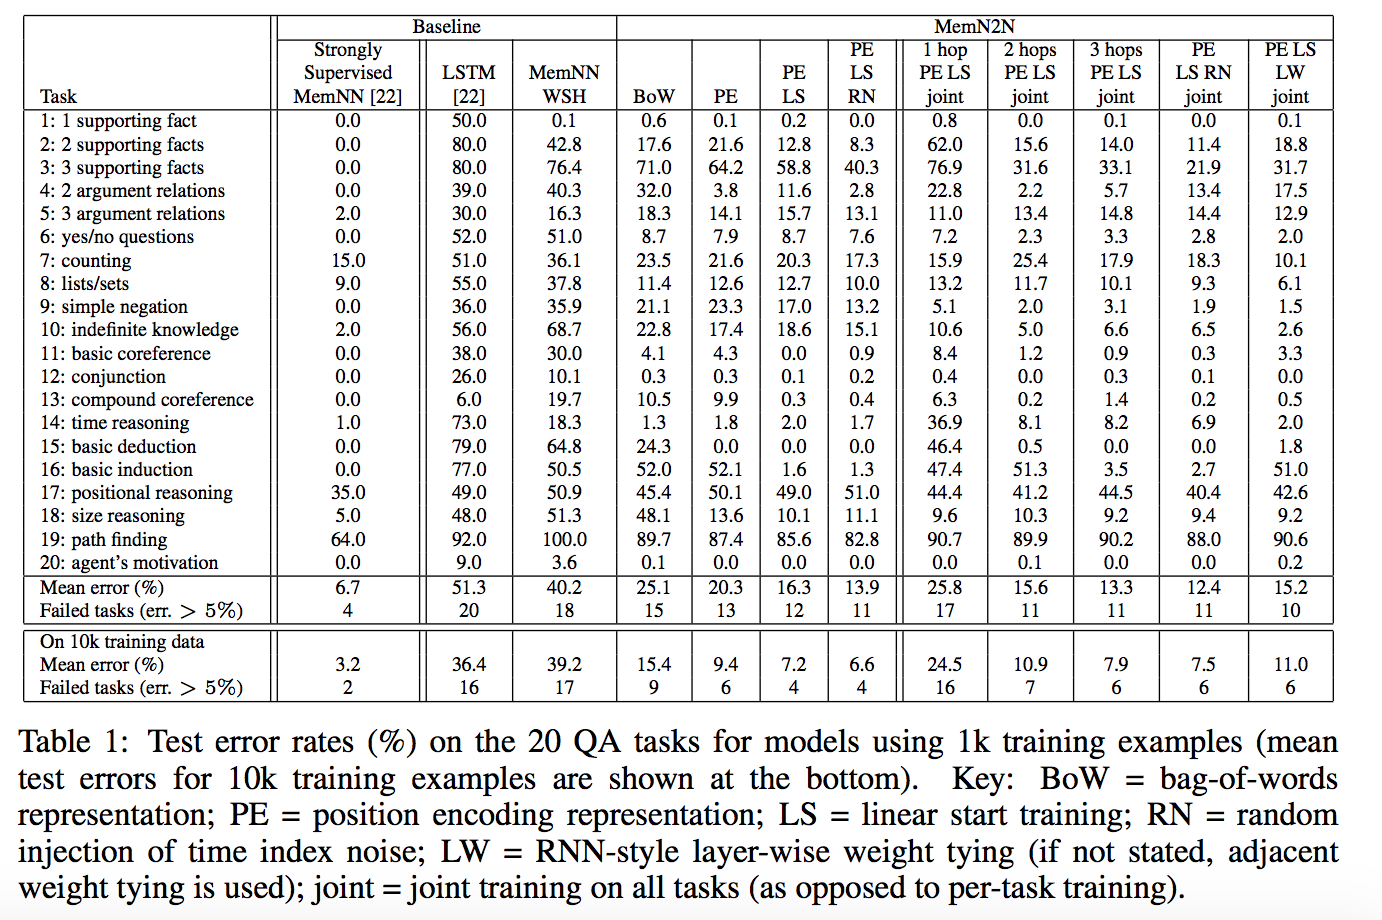

I'm rather satisfied with my performance on this one first task compared to the reported results of the paper above. This however took on average at least 300 epochs (500 here) to achieve accuracies > 90% (error  < 10%). I'm convinced this can be sped up greatly by a torch implementation I found online, which achieved this level of accuracy on most tasks in < 50 epochs. 

Referenced Torch implementation: https://github.com/jojonki/MemoryNetworks (not mine)

The linked code from the article is in Matlab code. Some ideas:
    
    --My time embedding matrices (TA, TC) scale up to the batch size for the layers they are called in this model. In the torch implementation they are fixed at (1 x MAX_MEM_LEN x VOCAB_LEN) and repeated for this operation, and I wonder in general if I have more parameters to train than this or the original article implementation.
    
    --My learning rate callback function decreases the LR periodically rather than based on the val_loss described in sec 4.1.
    
    --There is an awful lot of layering going on here. The tensorboard computational graph is enormous! Perhaps all of these object calls are less efficient than a pytorch implementation which can perform infer operations as part of a layer in the functional schema...
    
    --The joint training method may also improve performance in various tasks as described in the paper. 


Overall I learned a ton doing this project. There were no implementations of this algorithm with keras or the keras functional design that I could find, and making sure every operation was part of a layer, and that lambda operations needed to derive from backend functions so they could be mapped to the computational graph posed many many challenges. But now I have a better idea what kinds of problems are better solved in this kind of implementation versus using another tool, as well as how callback functions can be used to monitor performance, and how changes can (and can't) be applied to individual layers of a network. 
    

Additionally, right after this (2017) came the Dynamic Memory Model of Socher, et al. 

https://arxiv.org/pdf/1506.07285.pdf

The model performed better than this one on almost every task, using GRUs to encode the sentences (both ways, then concatenating the last states of both), and a MUCH more complicated scoring function. 